# Pancreatic cancer - Eduati 2020

Model from the paper: doi: 10.15252/msb.209690 (link: https://www.ncbi.nlm.nih.gov/pubmed/32073727)

## Obtain the file as input of BNMPy

As performed in `preprocessing.ipynb`, we first convert the SBML file to a BNMPy-compatible format ('input_files/Eduati2020.txt')

## Load it into BNMpy

In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sys
# import booleanNetwork module from ./src
from BNMPy import booleanNetwork as bn
from BNMPy import BMatrix  

In [3]:
file = 'input_files/Eduati2020.txt'
network = BMatrix.load_network_from_file(file)

equations = BMatrix.get_equations(file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)
connectivity_matrix = BMatrix.get_connectivity_matrix(equations, upstream_genes, gene_dict)
truth_table = BMatrix.get_truth_table(equations, upstream_genes)
ngenes = len(equations)

No initial state provided, using a random initial state


In [5]:
%%time
noise_level = 0.05 # noise
y = network.update_noise ( noise_level  , 10000) # simulation with noise
y


CPU times: user 175 ms, sys: 58.2 ms, total: 233 ms
Wall time: 180 ms


array([[0, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0]], dtype=int8)

## Reproduce the results in the paper

### Set the conditions for simulation


In [4]:
# Dic file to specify how should the values of the genes be changed when perturbed, 
# e.g. oncogene 'FLT3 = 1', TSG 'TP53 = 0'
# These genes will be set constant during the whole computation process.

file_perturbations = './input_files/perturbed_genes_Eduati2020.txt'
perturbations_dict = BMatrix.get_mutation_dict(file_perturbations)
print(perturbations_dict)

{'EGFR': 0, 'JAK': 0, 'Akt': 0, 'PDPK1': 0, 'MEK': 0, 'IKKs': 0, 'PI3K': 0, 'EGF': 1, 'TNF': 1}


In [5]:
all_conditions = ['EGF,AktP,PDPK1', # 1st row in Fig 2B
                'EGF,AktM', # 2nd
                'EGF,PI3K', # 3rd
                'EGF,AktP,PDPK1,AktM', # 4th
                'EGF,AktP,PDPK1,PI3K', # 5th
                'EGF,AktM,PI3K', # 6th
                'EGF' # Also test on untreated
                ]

### no noise

In [7]:
%%time
n = 1000
scores = {}

# Go through all mutation profiles 
for condition in all_conditions: 
    print('condition: ', condition)

    mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(condition, perturbations_dict, connectivity_matrix, gene_dict)

    # making the networks and running the simulation
    # print('starting simulation')

    network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
    network_traj = network.update(n)
    # network_traj = network.update_noise(0.05, 600)

    #calculating the scores  
    # print('getting final score')
    cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 

    # average value of all the nodes
    average_array = np.mean(cal_range, axis=0)

    # calculating the scores for Cas3
    final_score = average_array[gene_dict['Cas3']]
    scores[condition] = final_score

condition:  EGF,AktP,PDPK1
condition:  EGF,AktM
condition:  EGF,PI3K
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,AktM,PI3K
condition:  EGF
CPU times: user 246 ms, sys: 25.4 ms, total: 271 ms
Wall time: 262 ms


In [8]:
scores

{'EGF,AktP,PDPK1': 1.0,
 'EGF,AktM': 1.0,
 'EGF,PI3K': 1.0,
 'EGF,AktP,PDPK1,AktM': 1.0,
 'EGF,AktP,PDPK1,PI3K': 1.0,
 'EGF,AktM,PI3K': 1.0,
 'EGF': 1.0}

### Find the convergence steps

In [ ]:
%%time
avg_status = {}
scores_steps = {}

steps = list(range(10000, 1000001, 20000))
# steps = list(range(100, 600, 100))

# Go through all mutation profiles 
for condition in all_conditions: 
    scores = []
    
    print('condition: ', condition)

    mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(condition, perturbations_dict, connectivity_matrix, gene_dict)

    # making the networks and running the simulation
    # print('starting simulation')

    network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
    network_traj = network.update_noise(0.05, 1000000)
    # network_traj = network.update_noise(0.05, 600)

    for n in steps: 
        #calculating the scores  
        # print('getting final score')
        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 

        # average value of all the nodes
        average_array = np.mean(cal_range, axis=0)
        avg_status[condition] = average_array

        # calculating the scores for Cas3
        final_score = average_array[gene_dict['Cas3']]
        scores.append(final_score)

        # print('Score: ', final_score)
        # print('\n')

    scores_steps.update({condition: scores})
    

EGF,AktP,PDPK1
[0.33333333333332993, 0.25733333333333164, 0.5931428571428587, 0.08730158730158033, 0.12464646464647178, 0.3890909090909056, 0.3026666666666622, 0.05615686274509368, 0.1335603715170275, 0.033784461152885914, 0.10443064182195094, 0.0933217391304253, 0.16690370370371355, 0.2919795657726709, 0.10527252502781081, 0.10402737047898736, 0.07414718614718874, 0.12288803088803535, 0.08054054054054127, 0.011707317073172963, 0.04550198525241633, 0.10965374677003314, 0.04946572104019831, 0.06355188884065166, 0.03672669067626977, 0.019615242323345328, 0.008356775300166763, 0.03854545454545777, 0.04203389830508275, 0.06452347874409403, 0.04116055165235277, 0.0032185592185540735, 0.04025717566015219, 0.09077222582738464, 0.07011635027557306, 0.033671618753616794, 0.12627579908676134, 0.022573160173156026, 0.011050468518825074, 0.012952023753709518, 0.04719024245127823, 0.04138341601700457, 0.007875591615957855, 0.024600284127596073, 0.054722805284601606, 0.017960534089567215, 0.12826938

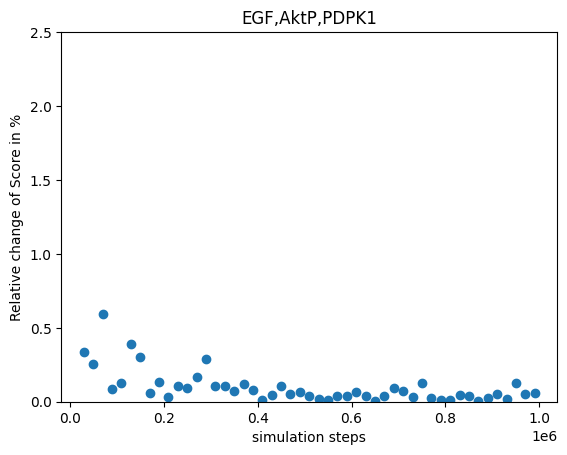

EGF,AktM
[0.31999999999999806, 0.012000000000000899, 0.0691428571428565, 0.30507936507936373, 1.0105050505050506, 0.29426573426573066, 0.4144615384615413, 0.3569411764705932, 0.08452012383901586, 0.11157894736842922, 0.27043478260869724, 0.1503652173913128, 0.046725925925927836, 0.040970625798220084, 0.1933481646273716, 0.11536656891495412, 0.01896103896104062, 0.023397683397685665, 0.0692030492030482, 0.021475922451530405, 0.18831537152580458, 0.11109043927648443, 0.04942789598109121, 0.05927051671732464, 0.01910364145658594, 0.07275619681834655, 0.027101200686108218, 0.13993620414672892, 0.18311031816830026, 0.04201166990830396, 0.10319542024459505, 0.09684493284493056, 0.049533869115958584, 0.05188838416613217, 0.13488058787507473, 0.05305807447424371, 0.09377168949772363, 0.03915151515152537, 0.04890678941312787, 0.052170651664318335, 0.04989736724676508, 0.08401984408220597, 0.0017660581474010506, 0.09719230272504653, 0.019733300407454024, 0.0064917877821146774, 0.0794816072439141

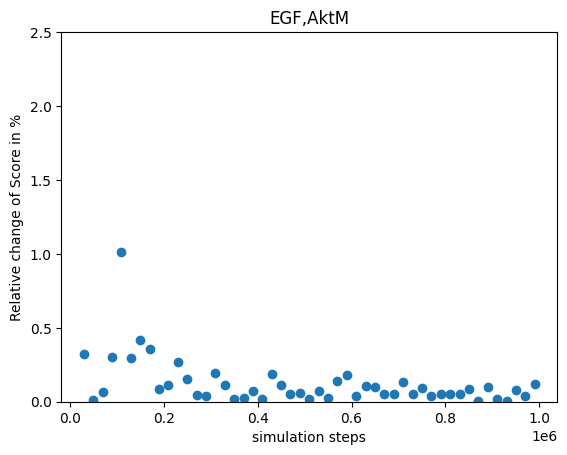

EGF,PI3K
[1.0666666666666713, 0.4146666666666743, 0.15371428571429036, 0.2012698412698466, 0.11171717171717388, 0.5450349650349628, 0.2716923076923061, 0.3216470588235265, 0.34185758513931574, 0.17483709273182768, 0.02443064182194865, 0.0885217391304316, 0.01392592592592834, 0.2907535121328242, 0.039043381535042165, 0.035992179863153506, 0.19530735930736176, 0.18905019305019977, 0.11171171171171501, 0.16601626016260473, 0.13547362450367917, 0.08298708010336941, 0.020671394799054443, 0.005922709509342816, 0.03173269307722437, 0.026318904920463737, 0.01014065180102719, 0.0992535885167456, 0.10713648528100084, 0.12011114198388073, 0.058199323445218276, 0.012771672771683118, 0.013203214695745036, 0.0069305645684636374, 0.10416411512553791, 0.07003665830600525, 0.006034703196344804, 0.06622683982684396, 0.006671050468509687, 0.07992186279106583, 0.06609846794585206, 0.012776754075116692, 0.05769574036510461, 0.020945370011626885, 0.005299419681448203, 0.04034030485642326, 0.0299898132427811

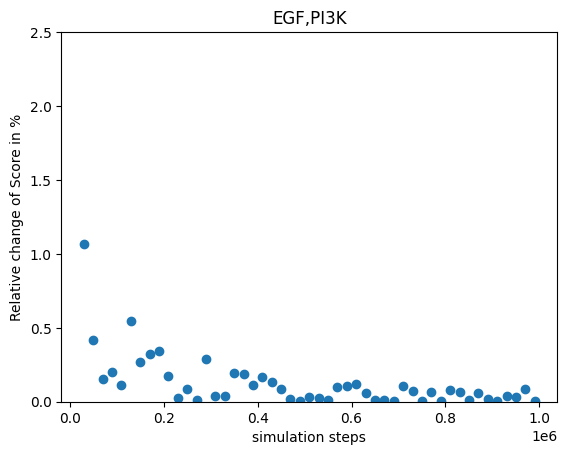

EGF,AktP,PDPK1,AktM
[3.046666666666664, 0.23733333333333384, 0.12742857142856723, 0.12634920634920777, 0.37050505050505445, 0.05734265734266275, 0.22871794871794915, 0.13960784313725716, 0.09925696594427214, 0.21964912280700855, 0.3031884057971057, 0.1829217391304372, 0.2513777777777726, 0.03363984674329412, 0.134460511679646, 0.04304985337243439, 0.20987012987012665, 0.23961389961389967, 0.049064449064450955, 0.05230769230769594, 0.051627906976747795, 0.17073901808786207, 0.1820898345153643, 0.1858358662613968, 0.158543417366952, 0.1499741028486823, 0.005975986277872991, 0.020759170653905645, 0.052851620576865876, 0.005368157821616926, 0.023122560499611033, 0.05860805860805618, 0.0036969001148023928, 0.03593770279038955, 0.11172075933864045, 0.06806482732008012, 0.058498630136982754, 0.04610909090909665, 0.034200230149605826, 0.027982497265199857, 0.02228171947047386, 0.11958610914245549, 0.03040973630831223, 0.038822161952734024, 0.03293986911964142, 0.02374571664893743, 0.0256932654

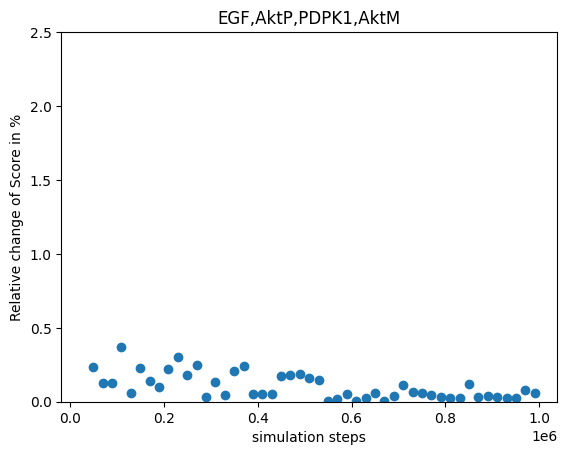

EGF,AktP,PDPK1,PI3K
[2.206666666666668, 0.3946666666666765, 0.245142857142866, 0.038412698412693125, 0.2973737373737406, 0.004895104895108471, 0.7030769230769174, 0.062352941176468946, 0.113436532507738, 0.2899248120300735, 0.31689440993788454, 0.19499130434782463, 0.07499259259259317, 0.22947637292465295, 0.09599555061179377, 0.0744281524926671, 0.07163636363636261, 0.1642162162162064, 0.16993762993763317, 0.07151969981238349, 0.1281225184344814, 0.046377260981911306, 0.05161229314420979, 0.13841945288753932, 0.06341736694678302, 0.04967073621902074, 0.06533104631217812, 0.09197448165868538, 0.05353553374963793, 0.07587663239789766, 0.027249544626584132, 0.01196581196580837, 0.035017221584388025, 0.0202336145360138, 0.03583588487446887, 0.18017364460736207, 0.0044310502283151365, 0.004200865800862985, 0.04069702449449597, 0.06387248007501123, 0.024649709950907983, 0.07062792345853275, 0.08457336037863694, 0.056952085754868875, 0.057305840227195315, 0.06236322816968176, 0.0164731182795

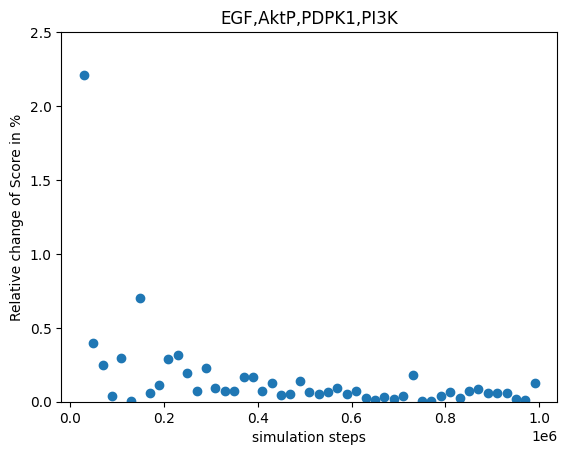

EGF,AktM,PI3K
[1.4000000000000012, 1.0480000000000045, 0.9337142857142933, 0.9146031746031791, 0.15111111111111297, 0.0953846153846083, 0.18994871794871804, 0.4206274509803931, 0.1205572755417994, 0.18907268170426095, 0.12815734989648497, 0.41645217391304, 0.05413333333332826, 0.045977011494258146, 0.10391546162402676, 0.07110459433039562, 0.1947359307359231, 0.012262548262542694, 0.14796950796950314, 0.13573483427141708, 0.06154282473057604, 0.02526098191214521, 0.05162174940899211, 0.1313677811550229, 0.209691876750695, 0.13217166111727519, 0.030195540308752822, 0.07614673046251186, 0.09437407077015347, 0.09542095026396913, 0.021425969294819325, 0.06749206349206949, 0.06250746268656737, 0.012507030067065994, 0.025605225556235567, 0.014613158402465576, 0.07090045662100364, 0.01875670995671319, 0.06523097156009294, 0.033298952961402506, 0.05073032872229266, 0.010715804394045847, 0.06977687626775753, 0.07091049980627595, 0.08757377454006177, 0.011334042301780478, 0.028962082625927366, 0

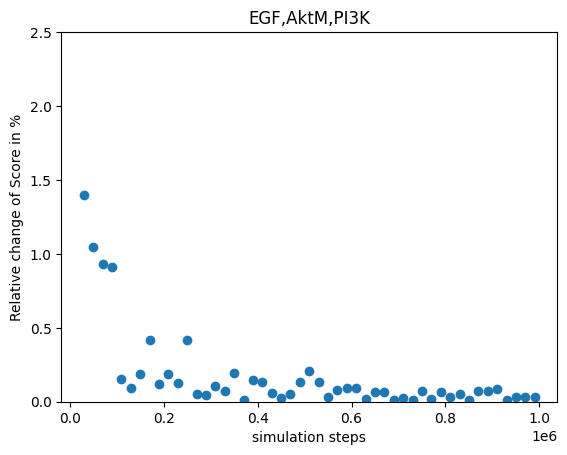


[4.080000000000005, 0.8000000000000007, 0.7657142857142807, 1.1968253968253961, 0.5602020202020275, 0.6675524475524552, 0.05979487179487153, 0.32101960784314265, 0.2107739938080555, 0.18015037593984706, 0.1470807453416101, 0.17885217391303554, 0.07087407407407875, 0.022477650063856824, 0.12602892102335783, 0.4104594330400779, 0.3158787878787872, 0.06583783783783437, 0.06523908523908828, 0.09332082551595233, 0.1962677254679468, 0.006067183462532544, 0.03235933806146063, 0.05395570994355392, 0.10697879151659873, 0.0644913059563379, 0.14489193825043545, 0.06384688995214605, 0.03951828724353401, 0.12012225618227568, 0.10432995055946748, 0.05224420024420029, 0.11837887485649512, 0.06587497296128841, 0.07079403959991959, 0.07007138722747719, 0.018199086757997307, 0.004824242424239511, 0.008584579976977924, 0.005938427879359498, 0.1683236650304898, 0.0693437278525888, 0.016603110209600924, 0.0445925351930776, 0.04440054327694565, 0.07775965969514242, 0.07161969439728466, 0.027429191535532915

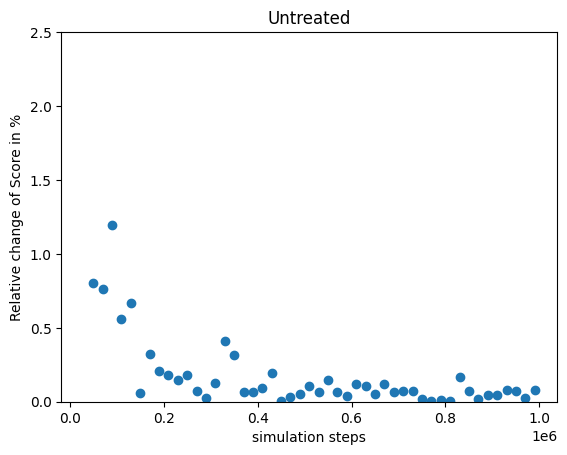

In [9]:
for condition in all_conditions:
    print(condition)
    scores = scores_steps[condition]
    
    # compute the difference in scores
    rel_diff_scores = []
    for i in range(1, len(scores)):
        diff = scores[i] - scores[i - 1]
        rel_diff_scores.append(100*abs(diff))
    
    print(rel_diff_scores)
    
    if condition=='':
        condition = 'Untreated'
    
    fig = plt.figure()
    plt.scatter(steps[1:], rel_diff_scores)
    plt.xlabel('simulation steps')
    plt.ylabel('Relative change of Score in %')
    plt.ylim(0, 2.5)
    plt.title(f'{condition}')
    plt.show()

### Run the simulation for 30 times

In [120]:
%%time

repeats = 30
avg_status_repeats = {}
scores_repeats = {}

# Go through all perturbation conditions
for condition in all_conditions: 
    scores = []
    avg_status = []
    
    print('condition: ', condition)

    for i in range(repeats):

        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(condition, perturbations_dict, connectivity_matrix, gene_dict)

        # making the networks and running the simulation
        network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        network_traj = network.update_noise(0.05, 1000000)

        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 

        # average value of all the nodes
        average_array = np.mean(cal_range, axis=0)
        avg_status.append(average_array)

        # calculating the scores for Cas3
        final_score = average_array[gene_dict['Cas3']]
        scores.append(final_score)

    scores_repeats.update({condition: scores})
    avg_status_repeats.update({condition: avg_status})

profile:  EGF,AktP,PDPK1
profile:  EGF,AktM
profile:  EGF,PI3K
profile:  EGF,AktP,PDPK1,AktM
profile:  EGF,AktP,PDPK1,PI3K
profile:  EGF,AktM,PI3K
profile:  
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
no_mutation
CPU times: user 46min 11s, sys: 1min 10s, total: 47min 22s
Wall time: 46min 38s


In [130]:
df_scores

,"EGF,AktP,PDPK1","EGF,AktM","EGF,PI3K","EGF,AktP,PDPK1,AktM","EGF,AktP,PDPK1,PI3K","EGF,AktM,PI3K",
0,0.734113,0.727420,0.728477,0.739636,0.741883,0.733560,0.716081
1,0.737834,0.729624,0.728434,0.736897,0.739358,0.734806,0.713261
2,0.735162,0.730834,0.729620,0.742063,0.740974,0.736400,0.714677
3,0.735911,0.729531,0.725707,0.742206,0.742543,0.730792,0.714671
4,0.730216,0.728420,0.730558,0.739808,0.743345,0.734356,0.715152
5,0.733396,0.728855,0.724657,0.742802,0.742822,0.734937,0.715499
6,0.734087,0.728729,0.729040,0.743602,0.740568,0.733756,0.712972
7,0.738424,0.728760,0.725297,0.741655,0.741269,0.736929,0.714853
8,0.734810,0.729580,0.728206,0.739653,0.742891,0.734998,0.715515
9,0.736788,0.724735,0.728384,0.742081,0.742240,0.734343,0.713176


In [131]:
df_scores = pd.DataFrame(scores_repeats)
df_scores.rename(columns={'': 'WT'}, inplace=True)
summary_stats = df_scores.describe().T  # Transpose to have profiles as index
summary_stats["sem"] = df_scores.sem(axis=0)  # Standard error of the mean
summary_stats

,count,mean,std,min,25%,50%,75%,max,sem
"EGF,AktP,PDPK1",30.0,0.734909,0.002069,0.730216,0.733432,0.734664,0.736220,0.739537,0.000378
"EGF,AktM",30.0,0.728340,0.001891,0.724735,0.727043,0.728623,0.729638,0.731729,0.000345
"EGF,PI3K",30.0,0.728065,0.002167,0.723358,0.726778,0.728340,0.729498,0.731968,0.000396
"EGF,AktP,PDPK1,AktM",30.0,0.741546,0.001620,0.736897,0.740779,0.741853,0.742261,0.745622,0.000296
"EGF,AktP,PDPK1,PI3K",30.0,0.741998,0.001403,0.739168,0.741047,0.742174,0.743076,0.744257,0.000256
"EGF,AktM,PI3K",30.0,0.734879,0.001728,0.730602,0.734327,0.734783,0.736152,0.737596,0.000316
WT,30.0,0.714566,0.001316,0.711473,0.713778,0.714678,0.715165,0.717535,0.000240


In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(summary_stats.index, summary_stats["mean"], yerr=summary_stats["std"], fmt='o', capsize=5, label="Mean ± SD")
plt.errorbar(summary_stats.index, summary_stats["mean"], yerr=summary_stats["sem"], fmt='o', capsize=5, label="Mean ± SEM", color='red', alpha=0.5)
plt.xlabel("Perturbation Condition")
plt.ylabel("Score")
plt.title("Score Distribution Across Perturbation Conditions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [136]:
# Extract statuses for selected genes
selected_genes = ["PI3K", "PIP3", "PDPK1", "Akt", "Mdm2", "p53", "Cas3"]

# Create a DataFrame where each row is a condition and columns are genes
condition_statuses = {condition: np.mean(avg_status_repeats[condition], axis=0) for condition in avg_status_repeats}
df_status = pd.DataFrame.from_dict(condition_statuses, orient="index")

# Subset the DataFrame to include only the selected genes
df_selected = df_status[[gene_dict[gene] for gene in selected_genes]]
df_selected.columns = selected_genes  # Rename columns with gene names
df = df_selected.rename(index={'': 'WT'})
df

,PI3K,PIP3,PDPK1,Akt,Mdm2,p53,Cas3
"EGF,AktP,PDPK1",0.755870,0.755718,0.000000,0.244892,0.611220,0.717717,0.734909
"EGF,AktM",0.749561,0.749182,0.500312,0.250629,0.608589,0.717054,0.728340
"EGF,PI3K",0.000000,0.447469,0.500020,0.349564,0.633189,0.710289,0.728065
"EGF,AktP,PDPK1,AktM",0.762323,0.761971,0.000000,0.237576,0.617011,0.724392,0.741546
"EGF,AktP,PDPK1,PI3K",0.000000,0.437997,0.000000,0.238087,0.617526,0.724411,0.741998
"EGF,AktM,PI3K",0.000000,0.440992,0.500197,0.244009,0.614136,0.724120,0.734879
WT,0.621391,0.667069,0.499173,0.382827,0.627056,0.695841,0.714566


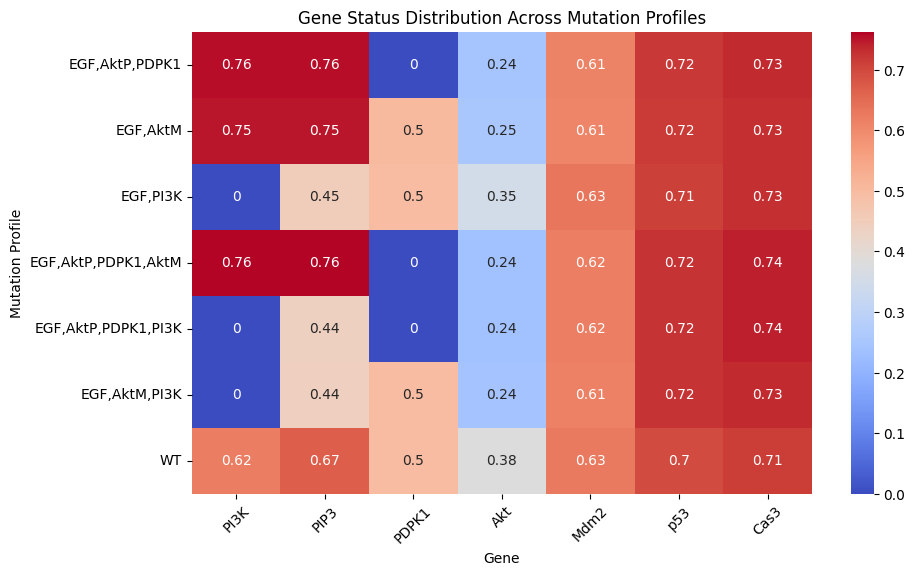

In [137]:
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", cbar=True)
plt.xlabel("Gene")
plt.ylabel("Perturbation Condition")
plt.title("Gene Status Distribution Across Perturbation Conditions")
plt.xticks(rotation=45)
plt.show()

## Test for different mutation profiles (celllines)

Test on the cell lines whose mutations are covered by the model.

The dictionary file for mutations 'mutations_Eduati2020.txt' is used to specify how should the values of the genes be changed when mutated.
It was obtained from the annotation in Cell Model Passport.  
   
AsPC1: https://cellmodelpassports.sanger.ac.uk/passports/SIDM00899  
BxPC3: https://cellmodelpassports.sanger.ac.uk/passports/SIDM00132


In [87]:
# Dic file to specify how should the values of the genes be changed when mutated

file_mutations = './input_files/mutations_Eduati2020.txt'
mutations_dict = BMatrix.get_mutation_dict(file_mutations)
print(mutations_dict)

{'Fbxw7': 0, 'RAS': 1, 'Rnf43': 0, 'Smad4': 0, 'p53': 0, 'Ep300': 0, 'JNKK': 0}


In [88]:
# List of perturbation conditions as in the paper Figure 2B
all_conditions = ['EGF,AktP,PDPK1', # 1st row in Fig 2B
                'EGF,AktM', # 2nd
                'EGF,PI3K', # 3rd
                'EGF,AktP,PDPK1,AktM', # 4th
                'EGF,AktP,PDPK1,PI3K', # 5th
                'EGF,AktM,PI3K', # 6th
                'EGF' # Also test on untreated
                ]

In [89]:
# List of cell lines and their mutation profiles
## Obtained from the GDSC database
cell_profiles = {}
cell_profiles['AsPC1'] = 'RAS,p53'
cell_profiles['BxPC3'] = 'p53'
cell_profiles['KP4'] = 'RAS'
cell_profiles['CAPAN1'] = 'RAS,p53,JNKK'
cell_profiles['Normal'] = ''

In [94]:
df_final_scores_paper = pd.DataFrame()
status_all = {}

for cell_line in cell_profiles:
    print("cell line: ", cell_line)
    profile = cell_profiles[cell_line]
    print("mutation profile: ", profile)
    n = 1000000
    final_scores = {}
    avg_status = {}

    # Go through all perturbation conditions

    for condition in all_conditions: 
        score = 0
        
        print('condition: ', condition)

        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutations_dict, connectivity_matrix, gene_dict, condition, perturbations_dict)

        # making the networks and running the simulation
        network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        network_traj = network.update_noise(0.05, 1000000)

        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 

        # average value of all the nodes
        average_array = np.mean(cal_range, axis=0)

        # calculating the scores for Cas3
        score = average_array[gene_dict['Cas3']]

        final_scores.update({condition: score})
        avg_status[condition] = average_array


    df_final_scores = pd.DataFrame(final_scores, index=[cell_line])
    df_final_scores.rename(columns={'EGF': 'EGF(Untreated)'}, inplace=True)
    df_final_scores_paper = pd.concat([df_final_scores_paper, df_final_scores])

    status_all[cell_line] = avg_status
    print("--------------------------------")


cell line:  AsPC1
mutation profile:  RAS,p53
condition:  EGF,AktP,PDPK1
condition:  EGF,AktM
condition:  EGF,PI3K
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,AktM,PI3K
condition:  EGF
--------------------------------
cell line:  BxPC3
mutation profile:  p53
condition:  EGF,AktP,PDPK1
condition:  EGF,AktM
condition:  EGF,PI3K
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,AktM,PI3K
condition:  EGF
--------------------------------
cell line:  KP4
mutation profile:  RAS
condition:  EGF,AktP,PDPK1
condition:  EGF,AktM
condition:  EGF,PI3K
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,AktM,PI3K
condition:  EGF
--------------------------------
cell line:  CAPAN1
mutation profile:  RAS,p53,JNKK
condition:  EGF,AktP,PDPK1
condition:  EGF,AktM
condition:  EGF,PI3K
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,AktM,PI3K
condition:  EGF
-------------------------

In [96]:
df_final_scores_paper

,"EGF,AktP,PDPK1","EGF,AktM","EGF,PI3K","EGF,AktP,PDPK1,AktM","EGF,AktP,PDPK1,PI3K","EGF,AktM,PI3K",EGF(Untreated)
AsPC1,0.744078,0.737416,0.731278,0.750702,0.748568,0.743466,0.729060
BxPC3,0.735838,0.727228,0.729556,0.740098,0.741334,0.737072,0.721204
KP4,0.741378,0.735786,0.733408,0.749774,0.750454,0.740640,0.726796
CAPAN1,0.746374,0.739592,0.740548,0.756876,0.757774,0.748202,0.732538
Normal,0.734014,0.725356,0.728070,0.740742,0.739592,0.731302,0.720688


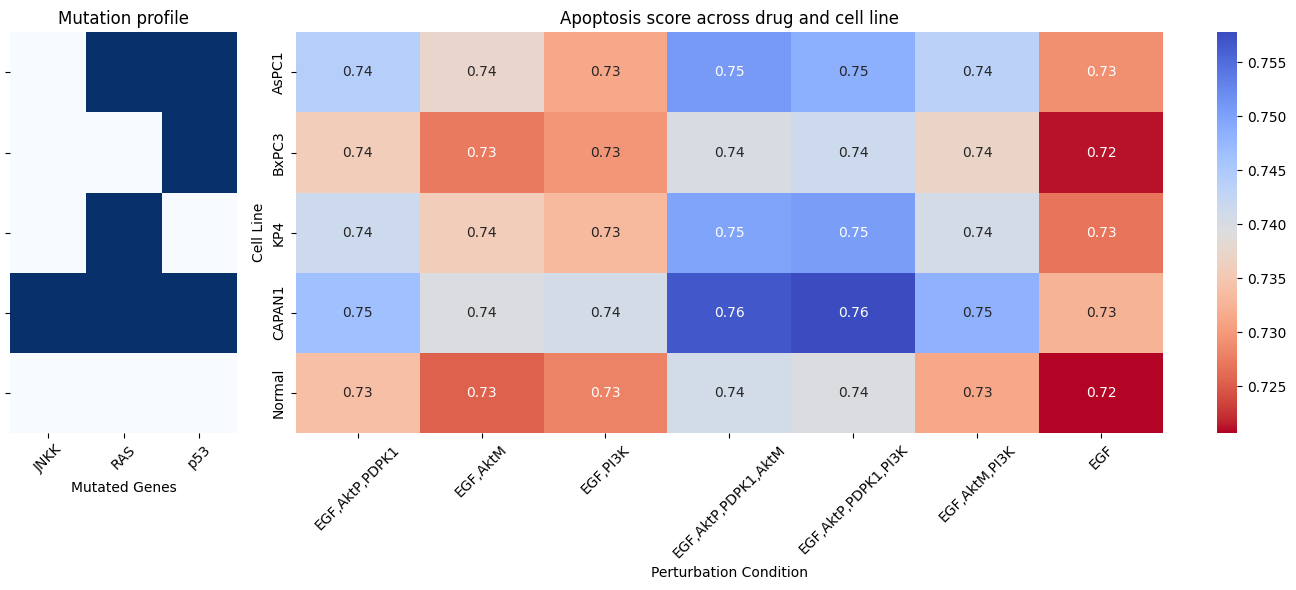

In [95]:
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 20)
ax_genes = fig.add_subplot(gs[0, :4])   # Gene panel takes up 4/20 of width on left
ax_main = fig.add_subplot(gs[0, 4:])    # Main heatmap takes up 16/20 of width on right

# main heatmap
sns.heatmap(df_final_scores_paper, annot=True, cmap="coolwarm_r", cbar=True, ax=ax_main)
ax_main.set_xlabel("Perturbation Condition")
ax_main.set_ylabel("Cell Line")
ax_main.set_title("Apoptosis score across drug and cell line")
ax_main.set_xticklabels(ax_main.get_xticklabels(), rotation=45)

# matrix for gene mutations
genes = sorted(list(set(','.join(cell_profiles.values()).split(',')) - set([''])))
mutation_matrix = pd.DataFrame(0, index=cell_profiles.keys(), columns=genes)
for cell, mutations in cell_profiles.items():
    if mutations:
        for gene in mutations.split(','):
            if gene in genes:
                mutation_matrix.loc[cell, gene] = 1

mutation_matrix = mutation_matrix.loc[df_final_scores_paper.index, :]
sns.heatmap(mutation_matrix, cmap="Blues", cbar=False, ax=ax_genes)
ax_genes.set_xlabel("Mutated Genes")
ax_genes.set_ylabel("")
ax_genes.set_title("Mutation profile")
ax_genes.set_xticklabels(ax_genes.get_xticklabels(), rotation=45)
ax_genes.set_yticklabels([])  # Hide y-tick labels
plt.tight_layout()
plt.show()

/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_75801/1747162402.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


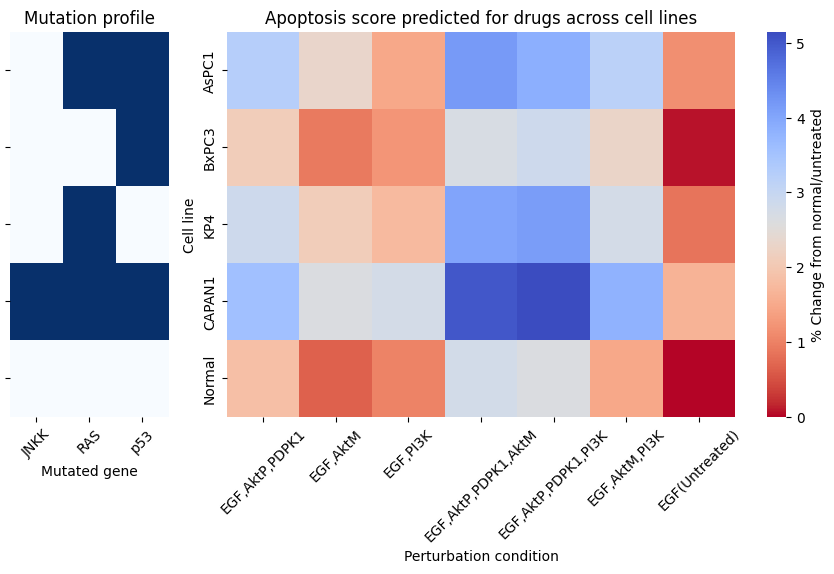

In [98]:
# normalized version
df_normalized = df_final_scores_paper.copy()
reference_value = df_final_scores_paper.loc['Normal', 'EGF(Untreated)']
df_normalized = (df_normalized / reference_value - 1) * 100

fig = plt.figure(figsize=(11, 5))
gs = fig.add_gridspec(1, 20, wspace=0.5)

ax_genes = fig.add_subplot(gs[0, :4])  # Gene panel on left
ax_main = fig.add_subplot(gs[0, 5:])   # Heatmap on right

sns.heatmap(df_normalized, annot=False, cmap="coolwarm_r", cbar=True, ax=ax_main)

cbar = ax_main.collections[0].colorbar
cbar.set_label('% Change from normal/untreated')

ax_main.set_xlabel("Perturbation condition")
ax_main.set_ylabel("Cell line")
ax_main.set_title("Apoptosis score predicted for drugs across cell lines")
ax_main.set_xticklabels(ax_main.get_xticklabels(), rotation=45)

genes = sorted(list(set(','.join(cell_profiles.values()).split(',')) - set([''])))
mutation_matrix = pd.DataFrame(0, index=cell_profiles.keys(), columns=genes)

for cell, mutations in cell_profiles.items():
    if mutations:
        for gene in mutations.split(','):
            if gene in genes:
                mutation_matrix.loc[cell, gene] = 1

mutation_matrix = mutation_matrix.loc[df_normalized.index, :]

sns.heatmap(mutation_matrix, cmap="Blues", cbar=False, ax=ax_genes)
ax_genes.set_xlabel("Mutated gene")
ax_genes.set_ylabel("")
ax_genes.set_title("Mutation profile")
ax_genes.set_xticklabels(ax_genes.get_xticklabels(), rotation=45)
ax_genes.set_yticklabels([])

plt.tight_layout()
plt.show()

## Test on more conditions (drugs)

In [83]:
df_final_scores_all

,EGFR,JAK,Akt,PDPK1,MEK,IKKs,PI3K,TNF,"EGFR,JAK","EGFR,Akt",...,"PDPK1,MEK,PI3K","PDPK1,MEK,TNF","PDPK1,IKKs,PI3K","PDPK1,IKKs,TNF","PDPK1,PI3K,TNF","MEK,IKKs,PI3K","MEK,IKKs,TNF","MEK,PI3K,TNF","IKKs,PI3K,TNF",Untreated
AsPC1,0.733578,0.739202,0.734190,0.733688,0.736288,0.735694,0.733382,0.734746,0.742680,0.738820,...,0.749318,0.749302,0.750568,0.747882,0.748560,0.747932,0.749906,0.749726,0.749128,0.729060
BxPC3,0.724856,0.728222,0.724276,0.730168,0.731098,0.728858,0.726004,0.728604,0.736860,0.734866,...,0.741814,0.742168,0.740868,0.742886,0.744322,0.744530,0.739944,0.742202,0.742872,0.721204
KP4,0.731700,0.732636,0.735814,0.734260,0.737354,0.736334,0.732136,0.736784,0.739532,0.742814,...,0.748674,0.748728,0.750858,0.751746,0.751360,0.744960,0.748882,0.748586,0.751800,0.726796
CAPAN1,0.742498,0.741490,0.740282,0.743514,0.743540,0.742742,0.743674,0.745178,0.748240,0.748052,...,0.757174,0.759108,0.755738,0.760560,0.757812,0.753738,0.757062,0.755826,0.754542,0.732538
Normal,0.730778,0.724604,0.727708,0.729530,0.725030,0.728084,0.728294,0.727982,0.736594,0.740404,...,0.745554,0.744436,0.744344,0.745058,0.743888,0.737932,0.739000,0.739710,0.743084,0.720688


In [84]:
# Dic file to specify how should the values of the genes be changed when perturbed, 
# e.g. oncogene 'FLT3 = 1', TSG 'TP53 = 0'
# These genes will be set constant during the whole computation process.

file_perturbations = './input_files/perturbed_genes_Eduati2020.txt'
perturbations_dict = BMatrix.get_mutation_dict(file_perturbations)
print(perturbations_dict)

{'EGFR': 0, 'JAK': 0, 'Akt': 0, 'PDPK1': 0, 'MEK': 0, 'IKKs': 0, 'PI3K': 0, 'EGF': 1, 'TNF': 1}


Generate all possible pairs, three-element, and four-element combinations while ensuring that 'EGF' is always included.

In [89]:
from itertools import combinations
other_components = [key for key in perturbations_dict.keys() if key != 'EGF']
all_conditions = []
for r in range(1, 4):  # r=1 for pairs, r=2 for three elements, r=3 for four elements
    for combo in combinations(other_components, r):
        condition = ['EGF'] + list(combo)
        all_conditions.append(",".join(condition))
all_conditions.append('') # also test on untreated
print(all_conditions)

['EGF,EGFR', 'EGF,JAK', 'EGF,Akt', 'EGF,PDPK1', 'EGF,MEK', 'EGF,IKKs', 'EGF,PI3K', 'EGF,TNF', 'EGF,EGFR,JAK', 'EGF,EGFR,Akt', 'EGF,EGFR,PDPK1', 'EGF,EGFR,MEK', 'EGF,EGFR,IKKs', 'EGF,EGFR,PI3K', 'EGF,EGFR,TNF', 'EGF,JAK,Akt', 'EGF,JAK,PDPK1', 'EGF,JAK,MEK', 'EGF,JAK,IKKs', 'EGF,JAK,PI3K', 'EGF,JAK,TNF', 'EGF,Akt,PDPK1', 'EGF,Akt,MEK', 'EGF,Akt,IKKs', 'EGF,Akt,PI3K', 'EGF,Akt,TNF', 'EGF,PDPK1,MEK', 'EGF,PDPK1,IKKs', 'EGF,PDPK1,PI3K', 'EGF,PDPK1,TNF', 'EGF,MEK,IKKs', 'EGF,MEK,PI3K', 'EGF,MEK,TNF', 'EGF,IKKs,PI3K', 'EGF,IKKs,TNF', 'EGF,PI3K,TNF', 'EGF,EGFR,JAK,Akt', 'EGF,EGFR,JAK,PDPK1', 'EGF,EGFR,JAK,MEK', 'EGF,EGFR,JAK,IKKs', 'EGF,EGFR,JAK,PI3K', 'EGF,EGFR,JAK,TNF', 'EGF,EGFR,Akt,PDPK1', 'EGF,EGFR,Akt,MEK', 'EGF,EGFR,Akt,IKKs', 'EGF,EGFR,Akt,PI3K', 'EGF,EGFR,Akt,TNF', 'EGF,EGFR,PDPK1,MEK', 'EGF,EGFR,PDPK1,IKKs', 'EGF,EGFR,PDPK1,PI3K', 'EGF,EGFR,PDPK1,TNF', 'EGF,EGFR,MEK,IKKs', 'EGF,EGFR,MEK,PI3K', 'EGF,EGFR,MEK,TNF', 'EGF,EGFR,IKKs,PI3K', 'EGF,EGFR,IKKs,TNF', 'EGF,EGFR,PI3K,TNF', 'EGF,JA

In [86]:
df_final_scores_all = pd.DataFrame()
status_all = {}

for cell_line in cell_profiles:
    print("cell line: ", cell_line)
    profile = cell_profiles[cell_line]
    print("mutation profile: ", profile)
    n = 1000000
    final_scores = {}
    avg_status = {}

    # Go through all perturbation conditions

    for condition in all_conditions: 
        score = 0
        
        print('condition: ', condition)

        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutations_dict, connectivity_matrix, gene_dict, condition, perturbations_dict)

        # making the networks and running the simulation
        network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        network_traj = network.update_noise(0.05, 1000000)

        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 

        # average value of all the nodes
        average_array = np.mean(cal_range, axis=0)

        # calculating the scores for Cas3
        score = average_array[gene_dict['Cas3']]

        final_scores.update({condition: score})
        avg_status[condition] = average_array


    df_final_scores = pd.DataFrame(final_scores, index=[cell_line])
    df_final_scores.rename(columns={'EGF': 'Untreated'}, inplace=True)
    df_final_scores_all = pd.concat([df_final_scores_all, df_final_scores])

    status_all[cell_line] = avg_status
    print("--------------------------------")


cell line:  AsPC1
mutation profile:  RAS,p53
condition:  EGF,EGFR
condition:  EGF,JAK
condition:  EGF,Akt
condition:  EGF,PDPK1
condition:  EGF,MEK
condition:  EGF,IKKs
condition:  EGF,PI3K
condition:  EGF,TNF
condition:  EGF,EGFR,JAK
condition:  EGF,EGFR,Akt
condition:  EGF,EGFR,PDPK1
condition:  EGF,EGFR,MEK
condition:  EGF,EGFR,IKKs
condition:  EGF,EGFR,PI3K
condition:  EGF,EGFR,TNF
condition:  EGF,JAK,Akt
condition:  EGF,JAK,PDPK1
condition:  EGF,JAK,MEK
condition:  EGF,JAK,IKKs
condition:  EGF,JAK,PI3K
condition:  EGF,JAK,TNF
condition:  EGF,Akt,PDPK1
condition:  EGF,Akt,MEK
condition:  EGF,Akt,IKKs
condition:  EGF,Akt,PI3K
condition:  EGF,Akt,TNF
condition:  EGF,PDPK1,MEK
condition:  EGF,PDPK1,IKKs
condition:  EGF,PDPK1,PI3K
condition:  EGF,PDPK1,TNF
condition:  EGF,MEK,IKKs
condition:  EGF,MEK,PI3K
condition:  EGF,MEK,TNF
condition:  EGF,IKKs,PI3K
condition:  EGF,IKKs,TNF
condition:  EGF,PI3K,TNF
condition:  EGF,EGFR,JAK,Akt
condition:  EGF,EGFR,JAK,PDPK1
condition:  EGF,EGFR,JA

In [108]:
df_final_scores_all.columns = [col.replace('EGF,', '') for col in df_final_scores_all.columns]
df_final_scores_all.to_csv('pancreatic_cancer_Eduati2020_all_conditions.csv')
df_final_scores_all

,EGFR,JAK,Akt,PDPK1,MEK,IKKs,PI3K,TNF,"EGFR,JAK","EGFR,Akt",...,"PDPK1,MEK,PI3K","PDPK1,MEK,TNF","PDPK1,IKKs,PI3K","PDPK1,IKKs,TNF","PDPK1,PI3K,TNF","MEK,IKKs,PI3K","MEK,IKKs,TNF","MEK,PI3K,TNF","IKKs,PI3K,TNF",Untreated
AsPC1,0.733578,0.739202,0.734190,0.733688,0.736288,0.735694,0.733382,0.734746,0.742680,0.738820,...,0.749318,0.749302,0.750568,0.747882,0.748560,0.747932,0.749906,0.749726,0.749128,0.729060
BxPC3,0.724856,0.728222,0.724276,0.730168,0.731098,0.728858,0.726004,0.728604,0.736860,0.734866,...,0.741814,0.742168,0.740868,0.742886,0.744322,0.744530,0.739944,0.742202,0.742872,0.721204
KP4,0.731700,0.732636,0.735814,0.734260,0.737354,0.736334,0.732136,0.736784,0.739532,0.742814,...,0.748674,0.748728,0.750858,0.751746,0.751360,0.744960,0.748882,0.748586,0.751800,0.726796
CAPAN1,0.742498,0.741490,0.740282,0.743514,0.743540,0.742742,0.743674,0.745178,0.748240,0.748052,...,0.757174,0.759108,0.755738,0.760560,0.757812,0.753738,0.757062,0.755826,0.754542,0.732538
Normal,0.730778,0.724604,0.727708,0.729530,0.725030,0.728084,0.728294,0.727982,0.736594,0.740404,...,0.745554,0.744436,0.744344,0.745058,0.743888,0.737932,0.739000,0.739710,0.743084,0.720688


In [84]:
status_all

NameError: name 'status_all' is not defined

In [5]:
import pandas as pd
df_final_scores_all = pd.read_csv('pancreatic_cancer_Eduati2020_all_conditions.csv', index_col=0)
df_final_scores_all

,EGFR,JAK,Akt,PDPK1,MEK,IKKs,PI3K,TNF,"EGFR,JAK","EGFR,Akt",...,"PDPK1,MEK,PI3K","PDPK1,MEK,TNF","PDPK1,IKKs,PI3K","PDPK1,IKKs,TNF","PDPK1,PI3K,TNF","MEK,IKKs,PI3K","MEK,IKKs,TNF","MEK,PI3K,TNF","IKKs,PI3K,TNF",Untreated
AsPC1,0.733578,0.739202,0.734190,0.733688,0.736288,0.735694,0.733382,0.734746,0.742680,0.738820,...,0.749318,0.749302,0.750568,0.747882,0.748560,0.747932,0.749906,0.749726,0.749128,0.729060
BxPC3,0.724856,0.728222,0.724276,0.730168,0.731098,0.728858,0.726004,0.728604,0.736860,0.734866,...,0.741814,0.742168,0.740868,0.742886,0.744322,0.744530,0.739944,0.742202,0.742872,0.721204
KP4,0.731700,0.732636,0.735814,0.734260,0.737354,0.736334,0.732136,0.736784,0.739532,0.742814,...,0.748674,0.748728,0.750858,0.751746,0.751360,0.744960,0.748882,0.748586,0.751800,0.726796
CAPAN1,0.742498,0.741490,0.740282,0.743514,0.743540,0.742742,0.743674,0.745178,0.748240,0.748052,...,0.757174,0.759108,0.755738,0.760560,0.757812,0.753738,0.757062,0.755826,0.754542,0.732538
Normal,0.730778,0.724604,0.727708,0.729530,0.725030,0.728084,0.728294,0.727982,0.736594,0.740404,...,0.745554,0.744436,0.744344,0.745058,0.743888,0.737932,0.739000,0.739710,0.743084,0.720688


/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_75801/1150332182.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


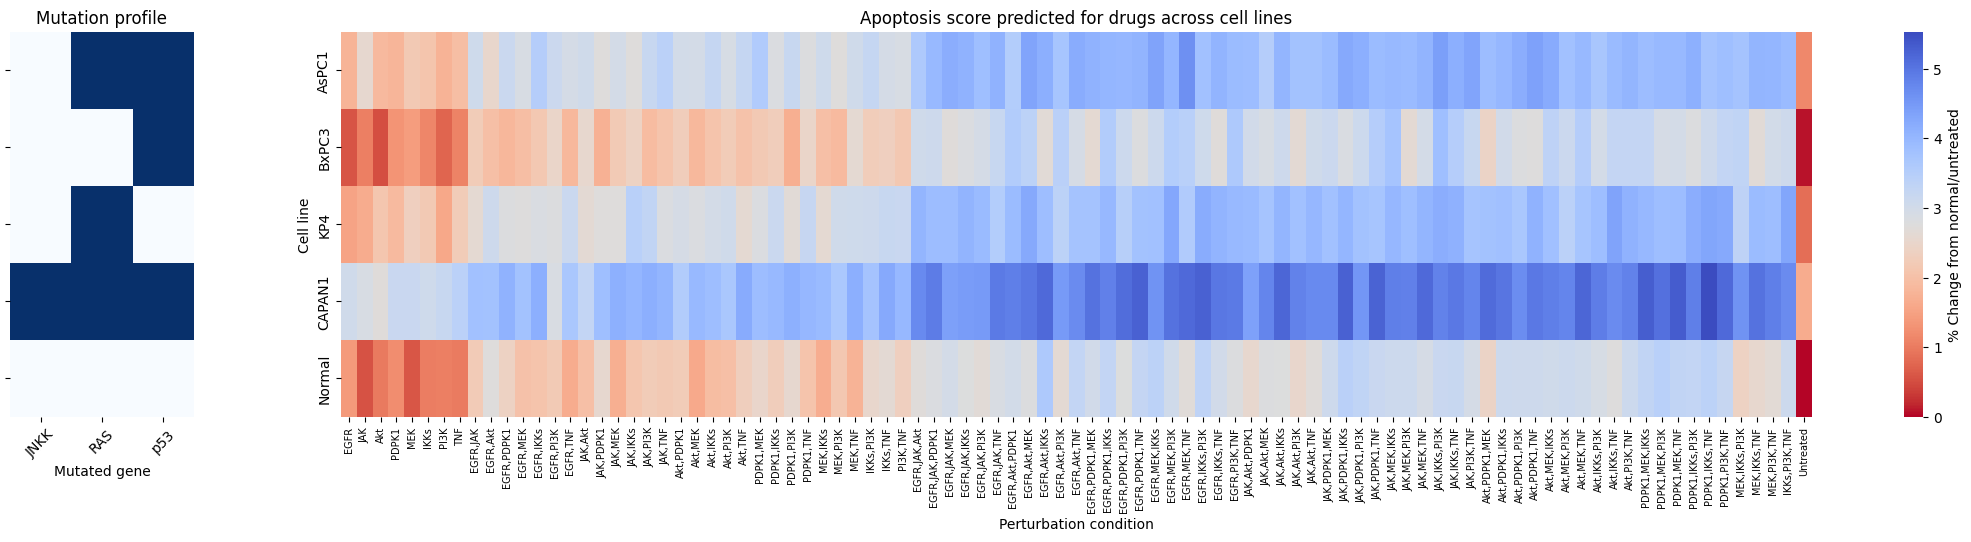

In [136]:
# normalized version
df_normalized = df_final_scores_all.copy()
reference_value = df_final_scores_all.loc['Normal', 'Untreated']
df_normalized = (df_normalized / reference_value - 1) * 100

fig = plt.figure(figsize=(28, 5))
gs = fig.add_gridspec(1, 20, wspace=0.5)

ax_genes = fig.add_subplot(gs[0, :2])  # Gene panel on left
ax_main = fig.add_subplot(gs[0, 3:])   # Heatmap on right
sns.heatmap(df_normalized, annot=False, cmap="coolwarm_r", cbar=True, ax=ax_main)

cbar = ax_main.collections[0].colorbar
cbar.set_label('% Change from normal/untreated')

ax_main.set_xlabel("Perturbation condition")
ax_main.set_ylabel("Cell line")
ax_main.set_title("Apoptosis score predicted for drugs across cell lines")
ax_main.set_xticklabels(ax_main.get_xticklabels(), rotation=90,fontsize=7)

genes = sorted(list(set(','.join(cell_profiles.values()).split(',')) - set([''])))
mutation_matrix = pd.DataFrame(0, index=cell_profiles.keys(), columns=genes)

for cell, mutations in cell_profiles.items():
    if mutations:
        for gene in mutations.split(','):
            if gene in genes:
                mutation_matrix.loc[cell, gene] = 1

mutation_matrix = mutation_matrix.loc[df_normalized.index, :]

sns.heatmap(mutation_matrix, cmap="Blues", cbar=False, ax=ax_genes)
ax_genes.set_xlabel("Mutated gene")
ax_genes.set_ylabel("")
ax_genes.set_title("Mutation profile")
ax_genes.set_xticklabels(ax_genes.get_xticklabels(), rotation=45)
ax_genes.set_yticklabels([])
plt.tight_layout()
plt.show()

/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_57804/2270746570.py:14: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


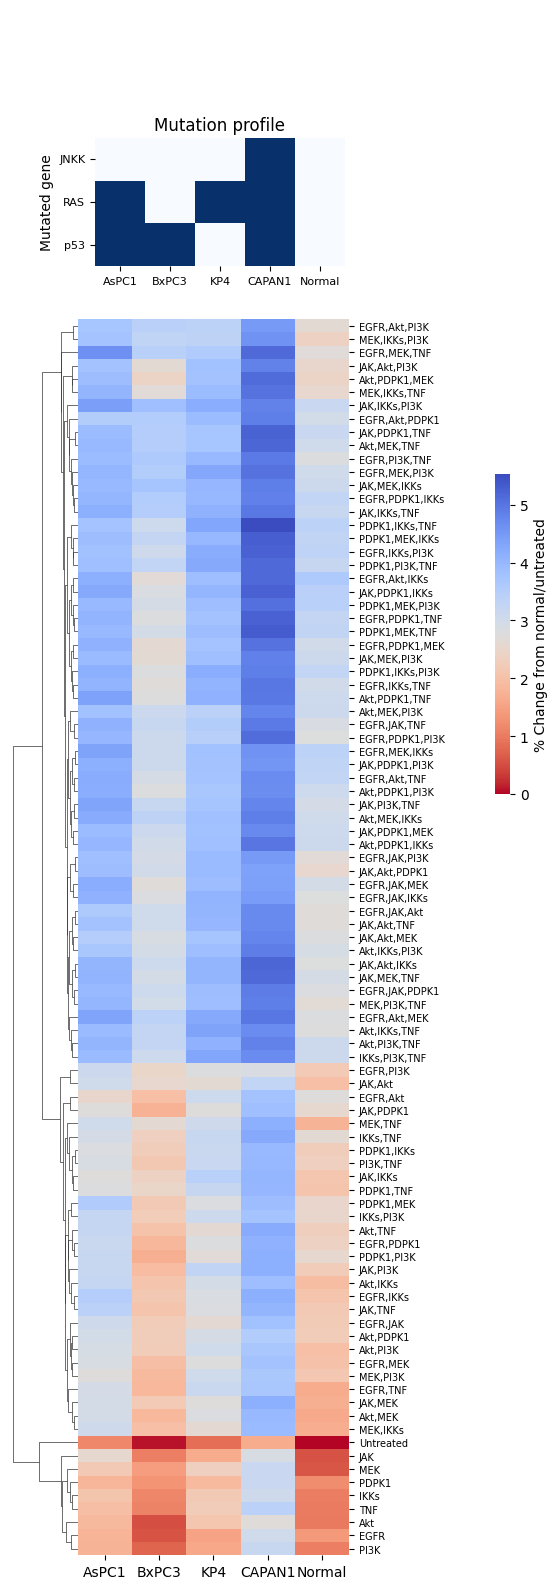

In [82]:
df_transposed = df_normalized.T

g = sns.clustermap(
    df_transposed, 
    cmap="coolwarm_r", 
    figsize=(5, 16), 
    col_cluster=False, 
    dendrogram_ratio=(0.2, 0.2),
    cbar_pos=(1, 0.5, 0.03, 0.2),
    cbar_kws={'label': '% Change from normal/untreated'},
    yticklabels=True
)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontsize=7)
plt.tight_layout()

genes = sorted(list(set(','.join(cell_profiles.values()).split(',')) - set([''])))
mutation_matrix = pd.DataFrame(0, index=cell_profiles.keys(), columns=genes)

for cell, mutations in cell_profiles.items():
    if mutations:
        for gene in mutations.split(','):
            if gene in genes:
                mutation_matrix.loc[cell, gene] = 1

mutation_matrix = mutation_matrix.loc[df_normalized.index, :].T
ax_genes = g.fig.add_axes([0.2, 0.83, 0.5, 0.08])  # [left, bottom, width, height]
sns.heatmap(mutation_matrix, cmap="Blues", cbar=False, ax=ax_genes)
ax_genes.set_xlabel("")
ax_genes.set_ylabel("Mutated gene")
ax_genes.set_title("Mutation profile")
ax_genes.set_xticklabels(ax_genes.get_xticklabels(), rotation=0, fontsize=8)
ax_genes.set_yticklabels(ax_genes.get_yticklabels(), rotation=0, fontsize=8)
plt.show()

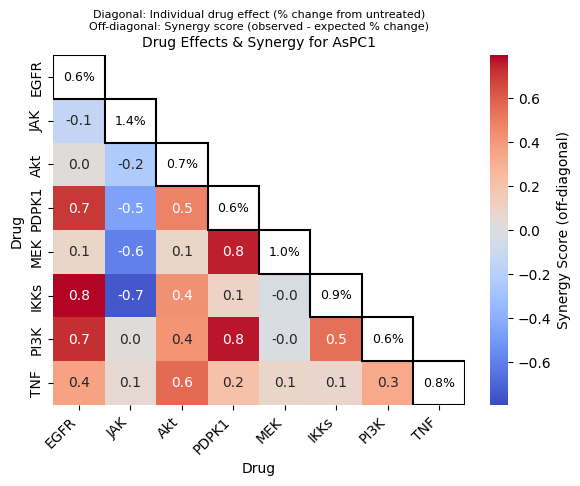

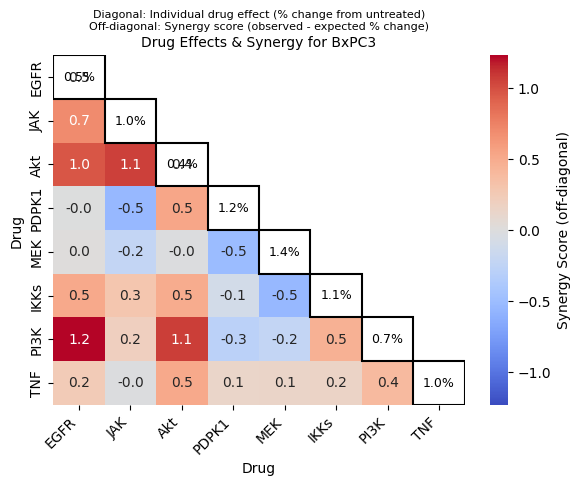

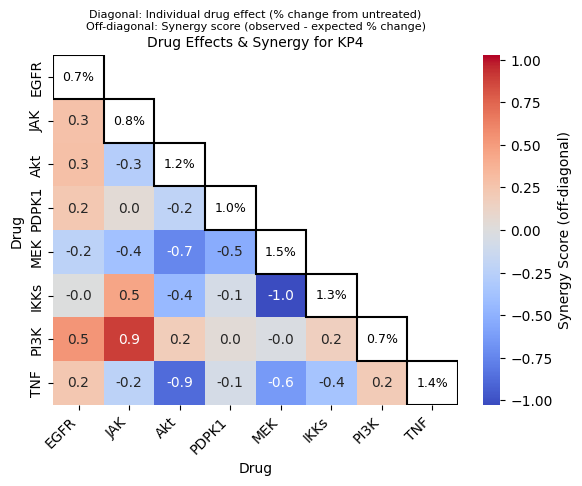

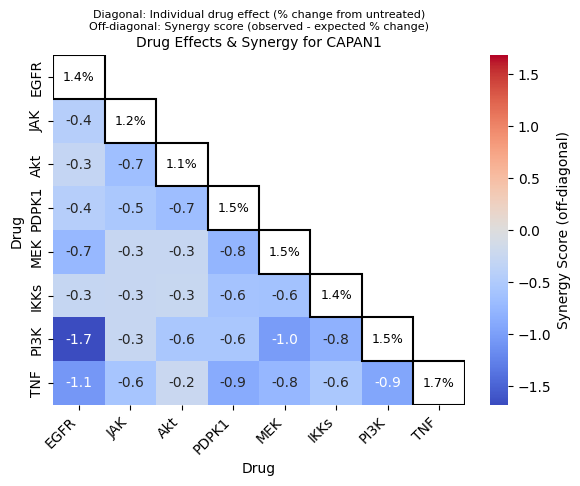

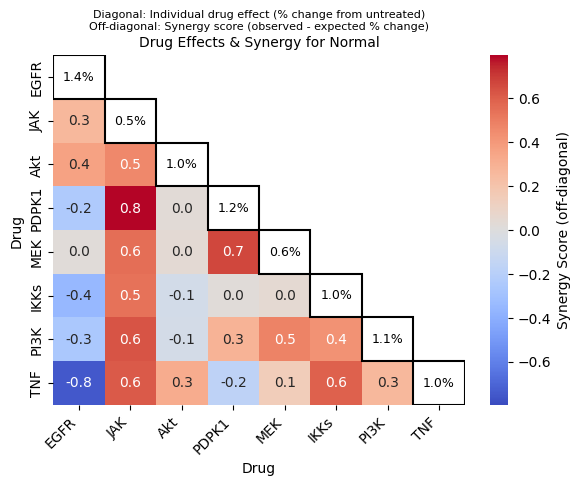

In [63]:
# see the synergy effect of drugs
def create_drug_synergy_matrix_with_diagonal(df, cell_line='AsPC1'):
    df_norm = df.copy()
    baseline = float(df.loc[cell_line, 'Untreated'])
    cell_changes = {}
    for col in df.columns:
        try:
            value = float(df.loc[cell_line, col])
            cell_changes[col] = ((value / baseline) - 1) * 100
        except Exception as e:
            print(f"Error calculating % change for {col}: {e}")
            cell_changes[col] = np.nan
    
    single_drugs = [col for col in df.columns if ',' not in col and col != 'Untreated']
    
    plt.figure(figsize=(6, 5))
    matrix_display = pd.DataFrame(np.nan, index=single_drugs, columns=single_drugs)
    matrix_colors = pd.DataFrame(np.nan, index=single_drugs, columns=single_drugs)
    individual_effects = {}
    for drug in single_drugs:
        if drug in cell_changes:
            matrix_display.loc[drug, drug] = cell_changes[drug]
            individual_effects[drug] = cell_changes[drug]
            # Set diagonal to NaN in color matrix so it's excluded from color scaling
            matrix_colors.loc[drug, drug] = np.nan

    for i, drug1 in enumerate(single_drugs):
        for j, drug2 in enumerate(single_drugs):
            if i > j:  # Only fill lower triangle
                combo_formats = [f"{drug1},{drug2}", f"{drug2},{drug1}"]
                combo_found = False
                
                for combo in combo_formats:
                    if combo in cell_changes:
                        effect1 = individual_effects.get(drug1, 0)
                        effect2 = individual_effects.get(drug2, 0)
                        expected = effect1 + effect2
                        observed = cell_changes[combo]
                        # Calculate synergy (observed - expected)
                        synergy = observed - expected
                        matrix_display.loc[drug1, drug2] = synergy
                        matrix_colors.loc[drug1, drug2] = synergy
                        combo_found = True
                        break
                if not combo_found:
                    matrix_display.loc[drug1, drug2] = np.nan
                    matrix_colors.loc[drug1, drug2] = np.nan
    
    matrix_display = matrix_display.astype(float)
    matrix_colors = matrix_colors.astype(float)

    mask = np.triu(np.ones_like(matrix_display, dtype=bool), k=1)
    vmin = np.nanmin(matrix_colors.values)
    vmax = np.nanmax(matrix_colors.values)
    abs_max = max(abs(vmin), abs(vmax))
    sns.heatmap(matrix_display, mask=mask, annot=True, fmt='.1f', 
               cmap='coolwarm', center=0, ax=plt.gca(),
               vmin=-abs_max, vmax=abs_max,
               cbar_kws={'label': 'Synergy Score (off-diagonal)'})
    
    # Override diagonal cell colors to make them white with black text
    for i, drug in enumerate(single_drugs):
        plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=True, edgecolor='black', facecolor='white', lw=1.5))
        value = matrix_display.loc[drug, drug]
        if not np.isnan(value):
            plt.text(i + 0.5, i + 0.5, f'{value:.1f}%', 
                    ha='center', va='center', fontsize=9, color='black')
    plt.text(len(single_drugs)/2, -0.8, 
             "Diagonal: Individual drug effect (% change from untreated)\nOff-diagonal: Synergy score (observed - expected % change)",
             ha='center', va='center', fontsize=8)
    plt.xlabel('Drug', fontsize=10)
    plt.ylabel('Drug', fontsize=10)
    plt.title(f'Drug Effects & Synergy for {cell_line}', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    # plt.savefig(f'{cell_line}_drug_synergy_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return matrix_display

for cell_line in df_final_scores_all.index:
    try:
        combo_matrix = create_drug_synergy_matrix_with_diagonal(df_final_scores_all, cell_line)
    except Exception as e:
        print(f"Error creating matrix for {cell_line}: {e}")

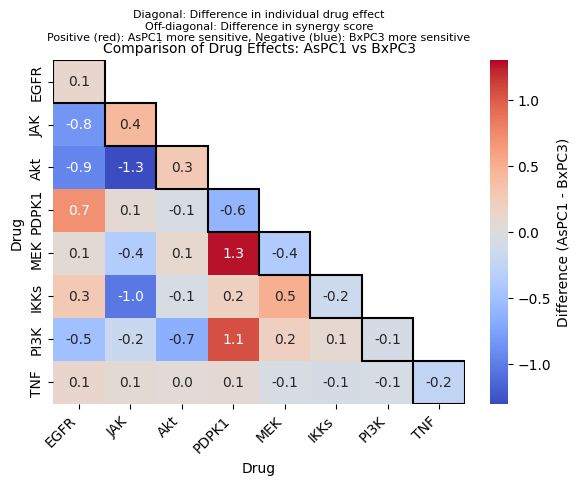

In [64]:
# Compare two cell lines
def create_cell_line_comparison_matrix(df, cell_line1='AsPC1', cell_line2='BxPC3'):
    df_norm = df.copy()
    baseline1 = float(df.loc[cell_line1, 'Untreated'])
    baseline2 = float(df.loc[cell_line2, 'Untreated'])
    cell_changes1 = {}
    cell_changes2 = {}
    for col in df.columns:
        try:
            value1 = float(df.loc[cell_line1, col])
            value2 = float(df.loc[cell_line2, col])
            cell_changes1[col] = ((value1 / baseline1) - 1) * 100
            cell_changes2[col] = ((value2 / baseline2) - 1) * 100
        except Exception as e:
            print(f"Error calculating % change for {col}: {e}")
            cell_changes1[col] = np.nan
            cell_changes2[col] = np.nan
    
    single_drugs = [col for col in df.columns if ',' not in col and col != 'Untreated']
    plt.figure(figsize=(6, 5))
    diff_matrix = pd.DataFrame(np.nan, index=single_drugs, columns=single_drugs)
    
    # Fill diagonal with difference in individual drug effects
    for drug in single_drugs:
        if drug in cell_changes1 and drug in cell_changes2:
            # Difference = cell_line1 effect - cell_line2 effect
            diff_matrix.loc[drug, drug] = cell_changes1[drug] - cell_changes2[drug]
    
    # Fill off-diagonal with difference in synergy effects
    for i, drug1 in enumerate(single_drugs):
        for j, drug2 in enumerate(single_drugs):
            if i > j:  # Only fill lower triangle
                combo_formats = [f"{drug1},{drug2}", f"{drug2},{drug1}"]
                combo_found = False
                
                for combo in combo_formats:
                    if combo in cell_changes1 and combo in cell_changes2:
                        # For cell line 1
                        effect1_1 = cell_changes1[drug1]
                        effect1_2 = cell_changes1[drug2]
                        expected1 = effect1_1 + effect1_2
                        observed1 = cell_changes1[combo]
                        synergy1 = observed1 - expected1
                        # For cell line 2
                        effect2_1 = cell_changes2[drug1]
                        effect2_2 = cell_changes2[drug2]
                        expected2 = effect2_1 + effect2_2
                        observed2 = cell_changes2[combo]
                        synergy2 = observed2 - expected2
                        diff_matrix.loc[drug1, drug2] = synergy1 - synergy2
                        combo_found = True
                        break
            
                if not combo_found:
                    diff_matrix.loc[drug1, drug2] = np.nan
    
    diff_matrix = diff_matrix.astype(float)
    mask = np.triu(np.ones_like(diff_matrix, dtype=bool), k=1)
    vmax = np.nanmax(np.abs(diff_matrix.values))
    sns.heatmap(diff_matrix, mask=mask, annot=True, fmt='.1f', 
               cmap='coolwarm', center=0, vmin=-vmax, vmax=vmax,
               ax=plt.gca(),
               cbar_kws={'label': f'Difference ({cell_line1} - {cell_line2})'})
    for i, drug in enumerate(single_drugs):
        plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=1.5))
    
    plt.text(len(single_drugs)/2, -0.8, 
             f"Diagonal: Difference in individual drug effect\nOff-diagonal: Difference in synergy score\nPositive (red): {cell_line1} more sensitive, Negative (blue): {cell_line2} more sensitive",
             ha='center', va='center', fontsize=8)
    plt.xlabel('Drug', fontsize=10)
    plt.ylabel('Drug', fontsize=10)
    plt.title(f'Comparison of Drug Effects: {cell_line1} vs {cell_line2}', fontsize=10)
    
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    # plt.savefig(f'{cell_line1}_vs_{cell_line2}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return diff_matrix

diff_matrix = create_cell_line_comparison_matrix(df_final_scores_all, 'AsPC1', 'BxPC3')